In [1]:
import PyPDF2
import stanfordnlp
import pickle
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import *
from tqdm import tqdm
import re
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import umap

In [2]:
_ = torch.manual_seed(0)

# TransformerSentence class
The following is the main class that given an input sentence as a string and the language model/tokenizer generates an object that's easy to access, manipulate and create visualizations on.

In [193]:
class TransformerSentence():
    def __init__(self, sentence_str, 
                 model=BertModel.from_pretrained('scibert-scivocab-uncased'), 
                 tokenizer=BertTokenizer.from_pretrained('scibert-scivocab-uncased')):
        
        self.raw_string = sentence_str
        self.model = model
        self.tokenizer = tokenizer
        self.summary = {}

        
    def write_summary(self, input_tokens=None, 
                      hidden_states=None, 
                      hidden_attentions=None,
                      print_tokens=True):
        
        if (input_tokens or hidden_states or hidden_attentions) is None:
            input_tokens, hidden_states, hidden_attentions = self.forward()
        
        # this replaces adds a "_{counter}" to the repreated tokens, so that 
        # they can be used uniquely as the keys for the embeddings dictionary
        input_tokens = TransformerSentence.make_unique(input_tokens)
        
        if print_tokens:
            print('Sentence Tokenization: ', input_tokens)
            
        # write summary into the object
        self.summary['input_tokens'] = input_tokens
        self.summary['states'] = hidden_states
        self.summary['attentions'] = hidden_attentions

        self.summary['token_embeddings'] = {input_token: hidden_states[:, i, :] 
                                            for i, input_token in enumerate(input_tokens)}
        
    def forward(self):
        encoded_inputs_dict = self.tokenizer.encode_plus(self.raw_string)
        input_ids = encoded_inputs_dict['input_ids']
        input_tensor = torch.tensor([input_ids])
        input_tokens = [self.tokenizer.decode(input_ids[j]).replace(' ', '') 
                        for j in range(len(input_ids))]
        
        final_attention, final_state, hidden_states_tup, hidden_attentions_tup = self.model(input_tensor)
        
        # stacking states and attentions along the first dimention (which corresponds to the batch when necessary)
        hidden_attentions = torch.cat(hidden_attentions_tup, dim=0) # 'layers', 'heads', 'queries', 'keys'
        hidden_states = torch.cat(hidden_states_tup, dim=0) # 'layers', 'tokens', 'embeddings'
        
        return input_tokens, hidden_states.detach(), hidden_attentions.detach()
    
    
    def attention_from_tokens(self, token1, token2, display=True):
        input_tokens = self.summary['input_tokens']
        
        if (token1 and token2) not in input_tokens:
            raise ValueError('One or both of the tokens introduced are not in the sentence!')
            
        idx1, idx2 = input_tokens.index(token1), input_tokens.index(token2)
        attention = self.summary['attentions'][:, :, idx1, idx2].numpy()
        if display:
            TransformerSentence.display_attention(attention, title=(token1, token2))
        return attention
    
    
    def attention_from_idx(self, i, j, display=True):
        attention = self.summary['attentions'][:, :, i, j].numpy()
        if display:
            TransformerSentence.display_attention(attention, title=f'Token idx: {(i, j)}')
        return attention
    
    def visualize_token_path(self, fit, tokens_to_follow=None, print_tokens=False, figsize=(10, 10)):
        
        if tokens_to_follow is None:
            all_tokens = self.summary['input_tokens']
            regex = re.compile(r'^[a-zA-Z]')
            tokens_to_follow = [i for i in all_tokens if regex.search(i)]
            
        if print_tokens: print(tokens_to_follow)  
            
        colors = list(range(len(tokens_to_follow)))
        projections = []
        layer_depth = self.summary['states'].size()[0]
        
        for i in range(layer_depth):
            layer_embeddings = self.summary['states'][i, :, :]
            projection = fit.transform(layer_embeddings)
            projections.append(projection)

        data = np.stack(projections, axis=0)
        fig, axs = plt.subplots(figsize=figsize)
        for token in tokens_to_follow:
            i = self.summary['input_tokens'].index(token)
            plt.plot(data[:,i,0], data[:,i,1], '-o', alpha=0.3)
            plt.annotate(s=token, xy=(data[0, i, 0], data[0, i, 1]))

        plt.show()
        
    def visualize_sentence_shape(self, fit, tokens_to_follow=None, print_tokens=False, figsize=(10, 10)):

        if tokens_to_follow is None:
            all_tokens = self.summary['input_tokens']
            regex = re.compile(r'^[a-zA-Z]')
            tokens_to_follow = [i for i in all_tokens if regex.search(i)]

        if print_tokens: print(tokens_to_follow)  

        colors = list(range(len(tokens_to_follow)))
        projections = []
        layer_depth = self.summary['states'].size()[0]
        
        # get list of indeces of the tokens to follow
        idxs = [self.summary['input_tokens'].index(token) for token in tokens_to_follow] 
        token_embeddings = self.summary['states'][-1, idxs, :]
        data = fit.transform(token_embeddings)

        fig, axs = plt.subplots(figsize=figsize)
        plt.plot(data[:,0], data[:,1], '-o')
        for i, token in enumerate(tokens_to_follow):
            plt.annotate(s=token, xy=(data[i, 0], data[i, 1]))
        plt.show()
    
    
    def save(self, name, path='.'):
        with open(os.path.join(path, name), 'wb') as file:
            pickle.dump(self, file)
    
    
    @staticmethod
    def visualize_embedding(embedding, title=None, vmax=None, vmin=None):
        if (vmax or vmin) is None:
            vmax = max(embedding)
            vmin = min(embedding)
            
        N = embedding.size()[0]
        h = math.ceil(math.sqrt(N))
        # N = a*b where abs(a-b) is minimum
        while (N % h != 0):
            h -= 1
        w = int(N / h)
        visualization = embedding.reshape((h, w)).numpy()
        fig, ax = plt.subplots()
        im = ax.imshow(visualization, vmax=vmax, vmin=vmin, cmap='viridis')
        fig.colorbar(im)
        if title is not None:
            ax.set_title(title)
        plt.show()
    
    @staticmethod
    def display_attention(attention, title=None):
        fig, ax = plt.subplots()
        im = ax.imshow(attention, vmin=0., vmax=1., cmap='viridis')
        fig.colorbar(im)
        if title is not None:
            ax.set_title(title)
        ax.set_xlabel('HEADS')
        ax.set_ylabel('LAYERS')
        plt.show()
    
    @staticmethod
    def load(name, path='.'):
        with open(os.path.join(path, name), 'rb') as file:
            SentenceObject = pickle.load(file)
        return SentenceObject
    
    @staticmethod
    def make_unique(L):
        unique_L = []
        for i, v in enumerate(L):
            totalcount = L.count(v)
            count = L[:i].count(v)
            unique_L.append(v + '_' + str(count+1) if totalcount > 1 else v)
        return unique_L

## Preload the models and tokenizers for later use

In [249]:
# Preloading models (this is the most costly)
BertBaseModel = BertModel.from_pretrained('bert-base-uncased')
BertBaseTokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
BertLargeModel = BertModel.from_pretrained('bert-large-uncased')
BertLargeTokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
SciBertModel = BertModel.from_pretrained('scibert-scivocab-uncased')
SciBertTokenizer = BertTokenizer.from_pretrained('scibert-scivocab-uncased')
SciBertBaseVocabModel = BertModel.from_pretrained('scibert-basevocab-uncased')
SciBertBaseVocabTokenizer = BertTokenizer.from_pretrained('scibert-basevocab-uncased')

## Example of the use of TransformerSentence

First, given a sentence, we generate three sentence objects with differente pretrained models

In [81]:
raw_sentence = "Computer Vision: What is the difference between local descriptors and global descriptors"

scibert_sentence = TransformerSentence(raw_sentence,
                                       model=SciBertModel,
                                       tokenizer=SciBertTokenizer)
bert_sentence = TransformerSentence(raw_sentence,
                                    model=BertBaseModel,
                                    tokenizer=BertBaseTokenizer)
bert_large_sentence = TransformerSentence(raw_sentence,
                                          model=BertLargeModel,
                                          tokenizer=BertLargeTokenizer)

Then by the method write_summary() we run the model and stores the interesting model data from that sentence. Use the flag `print_tokens` to see the tokenization.

In [82]:
scibert_sentence.write_summary(print_tokens=True)
bert_sentence.write_summary(print_tokens=True)
bert_large_sentence.write_summary(print_tokens=True)

Sentence Tokenization:  ['[CLS]', 'computer', 'vision', ':', 'what', 'is', 'the', 'difference', 'between', 'local', 'descriptors_1', 'and', 'global', 'descriptors_2', '[SEP]']
Sentence Tokenization:  ['[CLS]', 'computer', 'vision', ':', 'what', 'is', 'the', 'difference', 'between', 'local', 'des_1', '##cript_1', '##ors_1', 'and', 'global', 'des_2', '##cript_2', '##ors_2', '[SEP]']
Sentence Tokenization:  ['[CLS]', 'computer', 'vision', ':', 'what', 'is', 'the', 'difference', 'between', 'local', 'des_1', '##cript_1', '##ors_1', 'and', 'global', 'des_2', '##cript_2', '##ors_2', '[SEP]']


Next we see an example of how to get the model's attention from a token pair as a tensor NxM tensor (layers, heads), with the option of visualizing it.

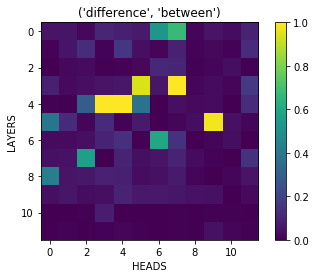

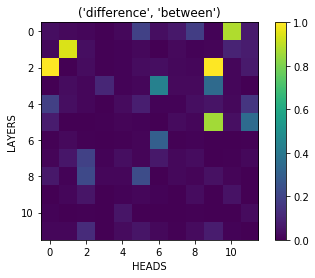

In [310]:
cv_att_scibert = scibert_sentence.attention_from_tokens('difference', 'between', display=True)
cv_att_bertbase = bert_sentence.attention_from_tokens('difference', 'between', display=True)

## Loading Quora Questions
With the `load_datset()` fuction, we get a txt file with a bunch of sentences and first we read the .txt file and store all the sentences in a list, where each sentence is a long string and then we generate a list of sentence objects and run `write_summary()` on each one of them.

In [218]:
def load_dataset(txt_path="../datasets/quora_questions.txt", 
                 MODEL=SciBertModel,
                 TOKENIZER=SciBertTokenizer):
    
    # Read input sequences from .txt file and put them in a list
    with open(txt_path) as f:
        text = f.read()
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    try:
        sentences.remove('') # remove possible empty strings
    except:
        None
    
    list_SentenceObj, ALL_INITIAL_EMBEDDINGS, ALL_CONTEXT_EMBEDDINGS = [], [], []
    
    for raw_sentence in tqdm(sentences):
        SentenceObj = TransformerSentence(raw_sentence,
                                          model=MODEL,
                                          tokenizer=TOKENIZER)
        SentenceObj.write_summary(print_tokens=False)
        list_SentenceObj.append(SentenceObj)
        ALL_INITIAL_EMBEDDINGS.append(SentenceObj.summary['states'][0, :, :])
        ALL_CONTEXT_EMBEDDINGS.append(SentenceObj.summary['states'][-1, :, :])

    ALL_INITIAL_EMBEDDINGS = torch.cat(ALL_INITIAL_EMBEDDINGS, dim=0)
    ALL_CONTEXT_EMBEDDINGS = torch.cat(ALL_CONTEXT_EMBEDDINGS, dim=0)
    
    return list_SentenceObj, ALL_INITIAL_EMBEDDINGS, ALL_CONTEXT_EMBEDDINGS

In [250]:
scibert_sentences, SCI_EMB_i, SCI_EMB_c = load_dataset(MODEL=SciBertModel, 
                                                       TOKENIZER=SciBertTokenizer)
bert_sentences, BASE_EMB_i, BASE_EMB_c = load_dataset(MODEL=BertBaseModel, 
                                                      TOKENIZER=BertBaseTokenizer)

100%|██████████| 301/301 [00:37<00:00,  7.95it/s]


Here we can see all the sentences with their index, which will be useful for later usage.

In [221]:
for i, sentence in enumerate(scibert_sentences):
    print(i, sentence.raw_string)

0 Are convolutional neural networks useful for tasks other than image classification?
1 Are non-causal temporal convolutions the equivalence of Bi-LSTM?
2 Are there any techniques, other than RNN/LSTM, to handle time series data?
3 Bayesian Inference: What is a Dirichlet process in layman's terms?
4 Can an objective account of statistical inference be based on frequentist methods and Bayesian methods?
5 Can Bayesian Network be combined with Deep Learning and/or reinforcement Learning to figure out causation?
6 Can deep neural networks learn the minimum function?
7 Can facial recognition tools be fooled?
8 Can recurrent neural networks with LSTM be used for time series prediction?
9 Can RNN be used for time series dynamic modelling?
10 If yes, how?
11 Can you explain the HMM algorithm?
12 Classification (machine learning): When should I use a K-NN classifier over a Naive Bayes classifier?
13 Computer Vision: What is the difference between HOG and SIFT feature descriptor?
14 Computer Vis

## Example of a few token pairs visualization and comparison

In [240]:
def view_attention_examples(sentences_list, token_pair, sentences_idx, figsize=(15, 3)):
    token1, token2 = token_pair
    list_att = [sentences_list[i].attention_from_tokens(token1, token2, display=False) 
                   for i in sentences_idx ]

    fig, axs = plt.subplots(1, 4, figsize=figsize)
    fig.suptitle(f'({token1}, {token2})')
    for i in range(4):
        axs[i].imshow(list_att[i], vmin=0., vmax=1)
    plt.show()

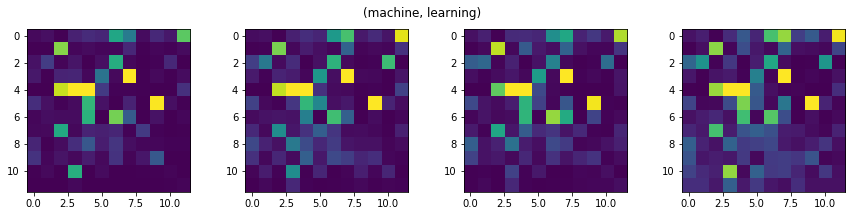

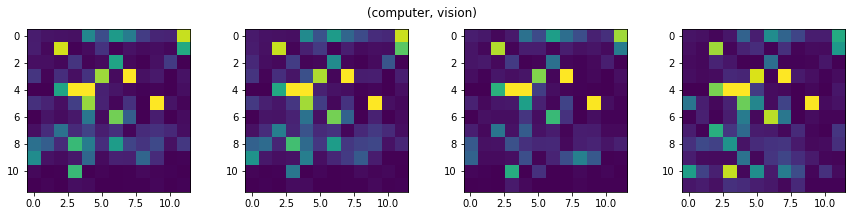

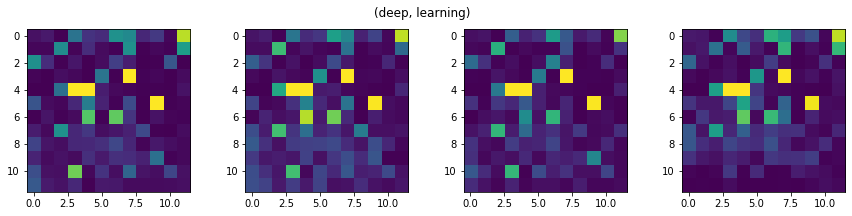

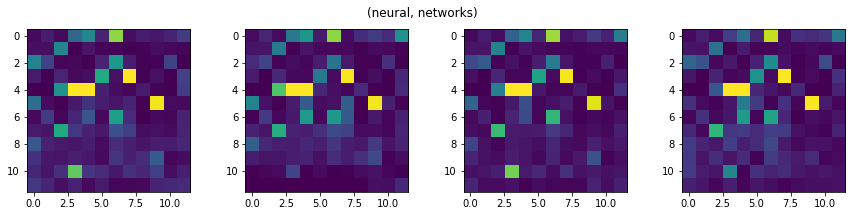

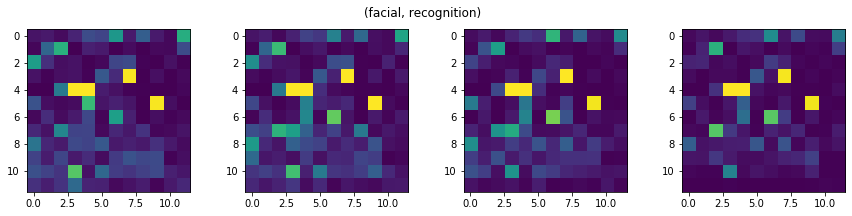

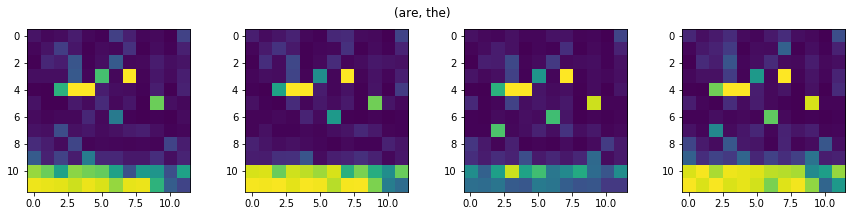

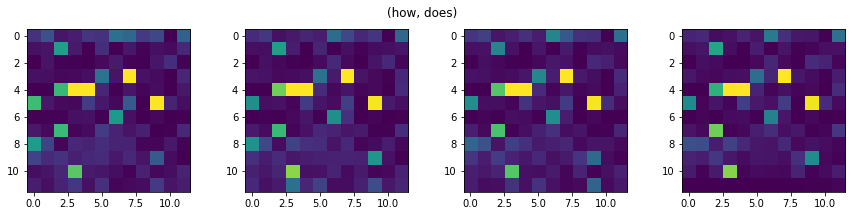

In [291]:
sentences_list = scibert_sentences

# MACHINE LEARNING
token_pair = 'machine', 'learning'
sentences_idx = [12, 16, 17, 19]
view_attention_examples(sentences_list, token_pair, sentences_idx)

# COMPUTER VISION     
token_pair = 'computer', 'vision'
sentences_idx = [13, 14, 17, 91]
view_attention_examples(sentences_list, token_pair, sentences_idx)

# DEEP LEARNING
token_pair = 'deep', 'learning'
sentences_idx = [22, 26, 93, 140]
view_attention_examples(sentences_list, token_pair, sentences_idx)
    
# NEURAL NETWORKS
token_pair = 'neural', 'networks'
sentences_idx = [0, 6, 8, 85]
view_attention_examples(sentences_list, token_pair, sentences_idx)

# FACIAL RECOGNITION
token_pair = 'facial', 'recognition'
sentences_idx = [7, 47, 182, 260]
view_attention_examples(sentences_list, token_pair, sentences_idx)

## ARE THE
token_pair = 'are', 'the'
sentences_idx = [24, 25, 78, 125]
view_attention_examples(sentences_list, token_pair, sentences_idx)

## HOW DOES
token_pair = 'how', 'does'
sentences_idx = [45, 46, 47, 48]
view_attention_examples(sentences_list, token_pair, sentences_idx)

## Example of the embedding similarity analysis
We start by creating a similarity function, in this case, a simple cosine similarity: `cos`.

In [242]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-08) # similarity func.

We now load one of our sentences to analyze.

In [293]:
sentence = scibert_sentences[132]
#sentence = bert_sentences[132]
print(sentence.raw_string)
print(sentence.summary['input_tokens'])

What are the benefits of using the Laplace prior over the Gaussian prior in the Bayesian inference?
['[CLS]', 'what', 'are', 'the_1', 'benefits', 'of', 'using', 'the_2', 'laplace', 'prior_1', 'over', 'the_3', 'gaussian', 'prior_2', 'in', 'the_4', 'bayesian', 'inference', '?', '[SEP]']


We can for instance, check how the similarity for every token pair in the sentence evolves as it goes through the language model

In [294]:
distance_evolution = {}
for token1 in sentence.summary['input_tokens']:
    for token2 in sentence.summary['input_tokens']:
        embs1 = sentence.summary['token_embeddings'][token1]#.clamp(-2, 2)
        embs2 = sentence.summary['token_embeddings'][token2]#.clamp(-2, 2)
        distance_evolution[(token1, token2)] = list(cos(embs1, embs2))

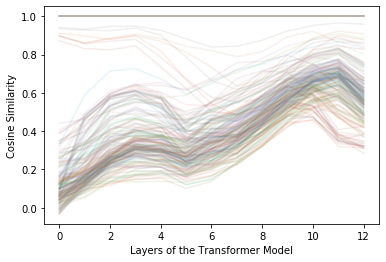

In [299]:
for key, d in distance_evolution.items():
    plt.plot(d, alpha=0.05)
    plt.xlabel('Layers of the Transformer Model')
    plt.ylabel('Cosine Similarity')

We can also visualize the embedding at every layer, to do a visual inspection of it:

### Token embeddings across layers

tensor(2.5319) tensor(-2.9621)
argmax, argmin tensor(300) tensor(181)


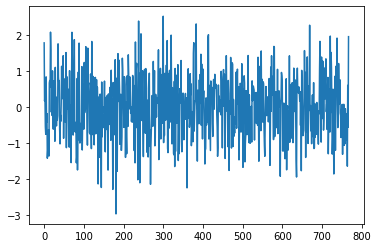

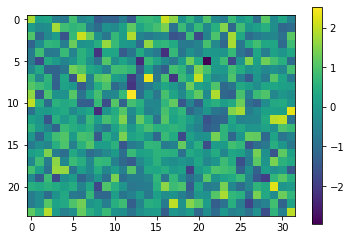

tensor(2.7207) tensor(-3.1027)
argmax, argmin tensor(300) tensor(375)


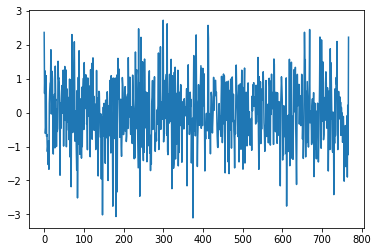

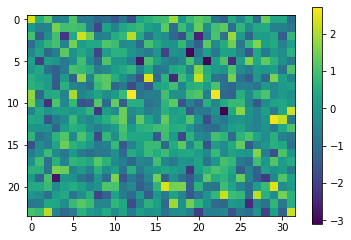

tensor(2.6151) tensor(-5.9886)
argmax, argmin tensor(300) tensor(147)


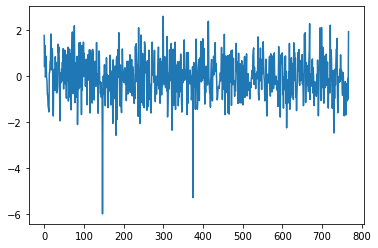

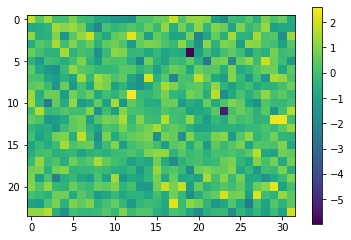

tensor(2.4463) tensor(-7.3142)
argmax, argmin tensor(300) tensor(147)


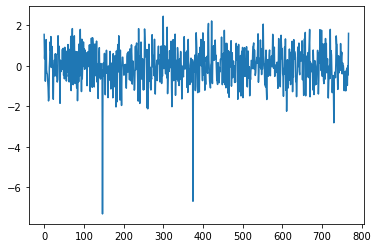

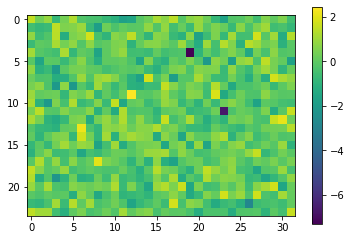

tensor(4.5178) tensor(-7.4598)
argmax, argmin tensor(422) tensor(147)


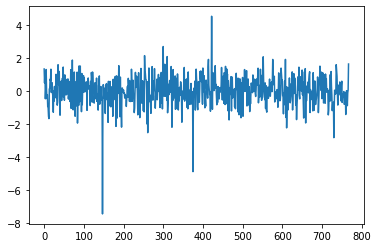

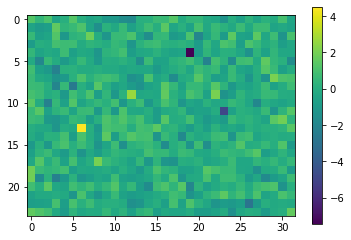

tensor(8.2087) tensor(-5.0925)
argmax, argmin tensor(422) tensor(147)


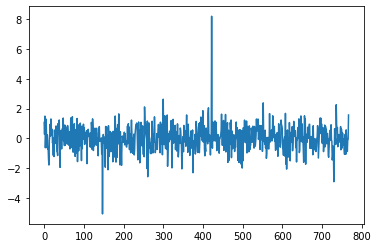

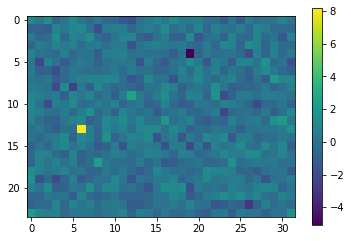

tensor(11.8991) tensor(-2.8437)
argmax, argmin tensor(422) tensor(730)


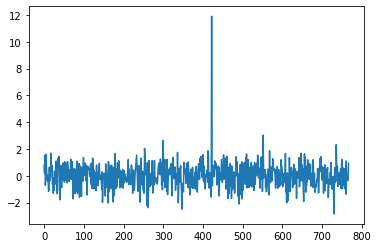

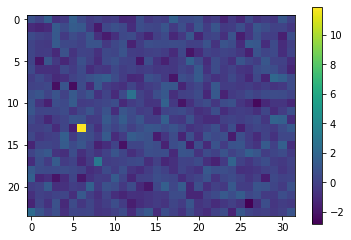

tensor(13.8762) tensor(-2.5904)
argmax, argmin tensor(422) tensor(499)


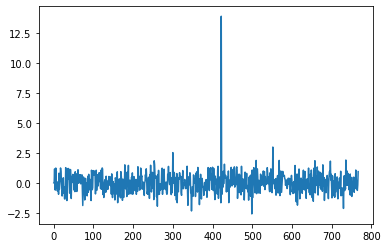

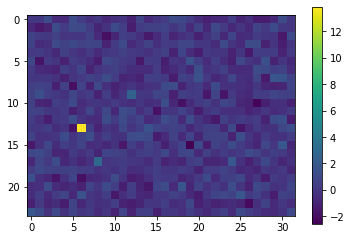

tensor(15.1588) tensor(-2.4653)
argmax, argmin tensor(422) tensor(614)


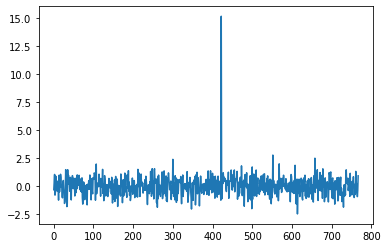

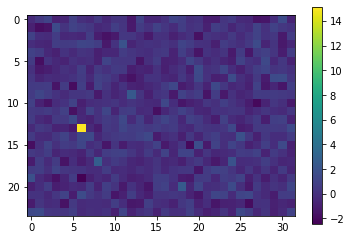

tensor(18.2940) tensor(-2.6252)
argmax, argmin tensor(422) tensor(614)


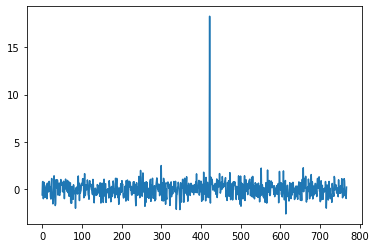

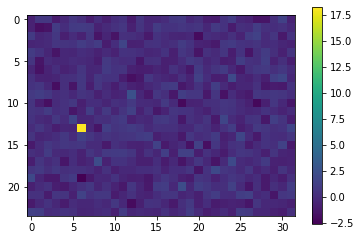

tensor(20.4016) tensor(-2.2531)
argmax, argmin tensor(422) tensor(84)


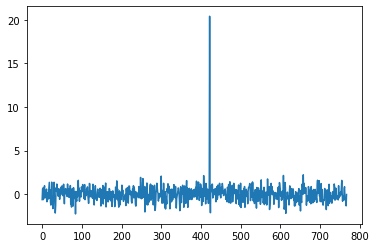

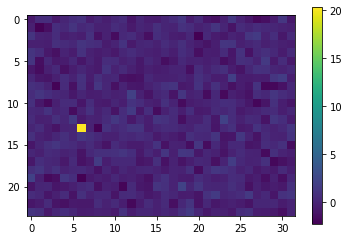

tensor(23.4568) tensor(-2.2753)
argmax, argmin tensor(422) tensor(424)


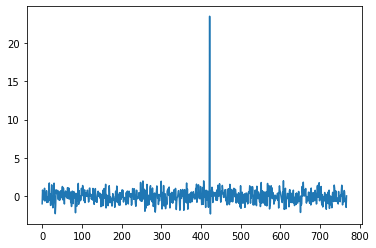

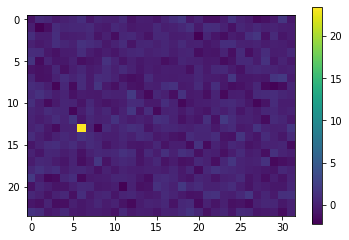

tensor(13.6843) tensor(-2.1192)
argmax, argmin tensor(422) tensor(33)


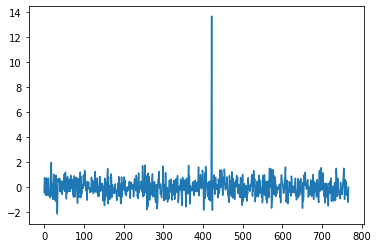

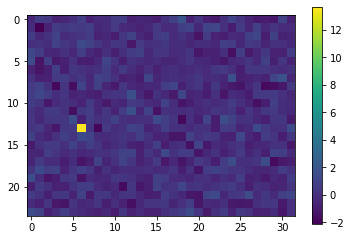

In [311]:
#### SEE TOKEN EMBEDDING ACROSS LAYERS ####

sentence = scibert_sentences[13]
#sentence = bert_sentences[13]
#sentence = TransformerSentence("With its public hearings over, the House Intelligence Committee plans to move forward without testimony by some of the key players in the Ukraine drama.",
#                              model=SciBertModel,
#                              tokenizer=SciBertTokenizer)
#sentence.write_summary()

token = '?'
for i in range(13):
    embedding = sentence.summary['token_embeddings'][token][i, :]#.clamp(-2, 2)
    print(max(embedding), min(embedding))
    print('argmax, argmin', torch.argmax(embedding), torch.argmin(embedding))
    fig, axs = plt.subplots()
    plt.plot(embedding)
    plt.show()
    sentence.visualize_embedding(embedding)

### Contextualized Embeddings Across Sentence

Computer Vision: What is the difference between HOG and SIFT feature descriptor?
['[CLS]', 'computer', 'vision', ':', 'what', 'is', 'the', 'difference', 'between', 'hog', 'and', 'si', '##ft', 'feature', 'des', '##cript', '##or', '?', '[SEP]']
Token: [CLS] | argmax, argmin: tensor(205) tensor(752)


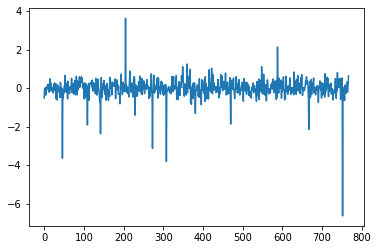

Token: computer | argmax, argmin: tensor(121) tensor(752)


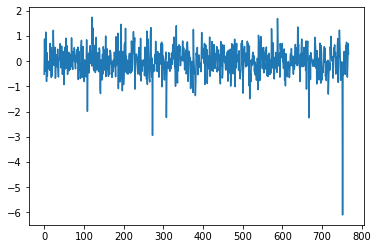

Token: vision | argmax, argmin: tensor(636) tensor(308)


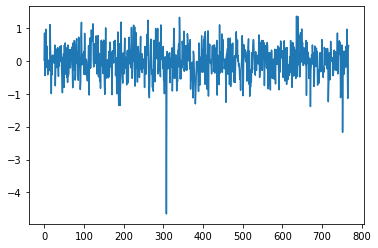

Token: : | argmax, argmin: tensor(225) tensor(308)


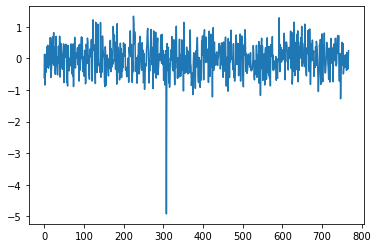

Token: what | argmax, argmin: tensor(630) tensor(308)


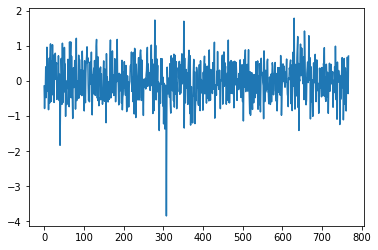

Token: is | argmax, argmin: tensor(352) tensor(432)


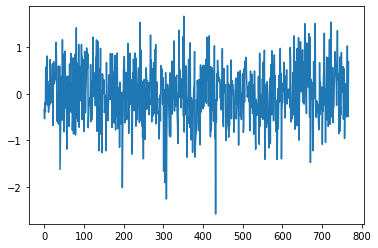

Token: the | argmax, argmin: tensor(352) tensor(308)


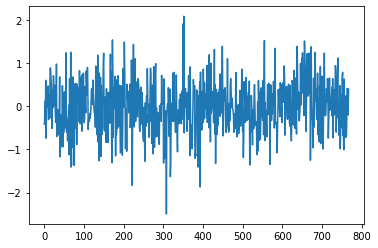

Token: difference | argmax, argmin: tensor(657) tensor(308)


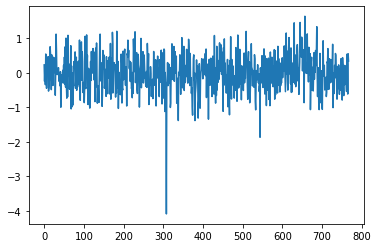

Token: between | argmax, argmin: tensor(229) tensor(308)


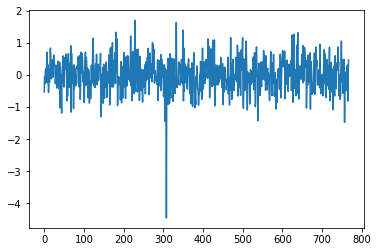

Token: hog | argmax, argmin: tensor(408) tensor(308)


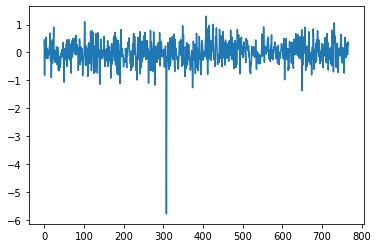

Token: and | argmax, argmin: tensor(327) tensor(308)


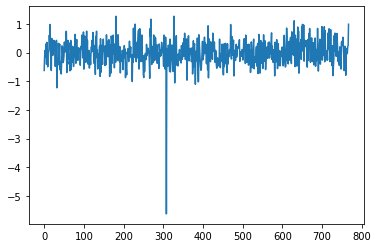

Token: si | argmax, argmin: tensor(15) tensor(308)


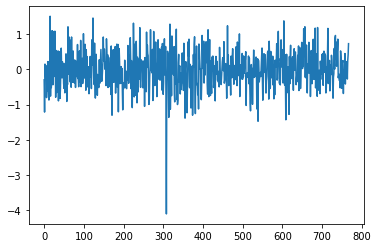

Token: ##ft | argmax, argmin: tensor(645) tensor(308)


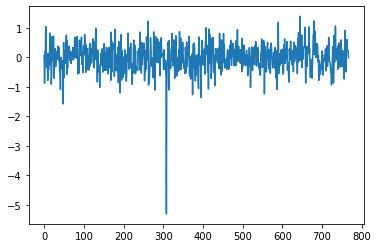

Token: feature | argmax, argmin: tensor(123) tensor(308)


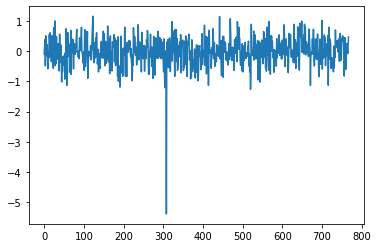

Token: des | argmax, argmin: tensor(630) tensor(308)


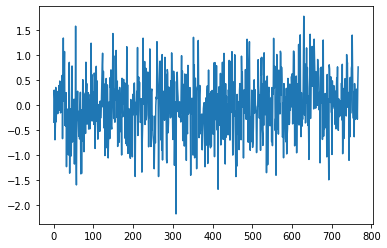

Token: ##cript | argmax, argmin: tensor(487) tensor(414)


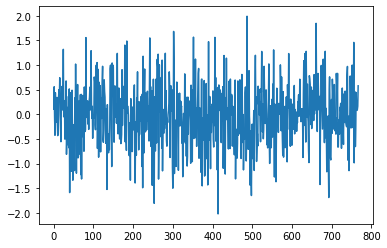

Token: ##or | argmax, argmin: tensor(487) tensor(308)


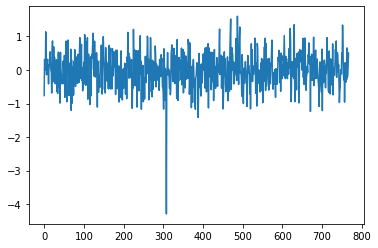

Token: ? | argmax, argmin: tensor(657) tensor(308)


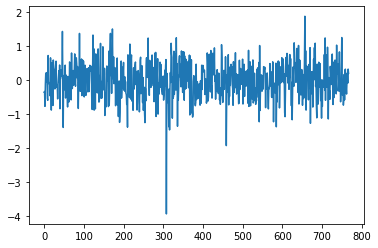

Token: [SEP] | argmax, argmin: tensor(123) tensor(180)


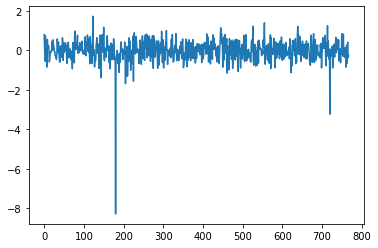

In [313]:
#### SEE CONTEXTUALIZED EMBEDDING ACROSS SENTENCE ####

#sentence = scibert_sentences[13]
sentence = bert_sentences[13]
#sentence = TransformerSentence("With its public hearings over, the House Intelligence Committee plans to move forward without testimony by some of the key players in the Ukraine drama.",
#                              model=SciBertModel,
#                              tokenizer=SciBertTokenizer)
#sentence.write_summary()

print(sentence.raw_string)
print(sentence.summary['input_tokens'])

for token in sentence.summary['input_tokens']:
    embedding = sentence.summary['token_embeddings'][token][-1, :]#.clamp(-2, 2)
    #print(max(embedding), min(embedding))
    print(f'Token: {token} | argmax, argmin:', torch.argmax(embedding), torch.argmin(embedding))
    fig, axs = plt.subplots()
    plt.plot(embedding)
    plt.show()
    #sentence.visualize_embedding(embedding)

## Dimensionality reduction
To preform a more insightful qualitative analysis, we can use a dimensionality reduction techinque such as UMAP, which tries to preserve as much as possible the data structure to lower dimensions.

In [302]:
# LOAD THE FIT OBJECT WITH ALL THE EMBEDDINGS FROM THE DATASET
fit = umap.UMAP(n_neighbors=60, n_components=2, metric='cosine', n_epochs=None, learning_rate=1.0, 
                init='spectral', min_dist=0.1, spread=1.0, set_op_mix_ratio=1.0, local_connectivity=1.0, 
                repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None, 
                random_state=None, metric_kwds=None, angular_rp_forest=False, target_n_neighbors=-1, 
                target_metric='categorical', target_metric_kwds=None, target_weight=0.5, transform_seed=0, 
                verbose=False)
_ = fit.fit(BASE_EMB_i) # ALL_EMBEDDINGS.size() = (n_samples, n_dimensions)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


### Tokens path visualization
Again, we pick a sentence we want to visualize.

In [314]:
sentence = bert_sentences[85]
print(sentence.raw_string)
print(sentence.summary['input_tokens'])

In what situation should I use neural networks instead of machine learning algorithms?
['[CLS]', 'in', 'what', 'situation', 'should', 'i', 'use', 'neural', 'networks', 'instead', 'of', 'machine', 'learning', 'algorithms', '?', '[SEP]']


And run the `visualize_token_path()` method.

['in', 'what', 'situation', 'should', 'i', 'use']


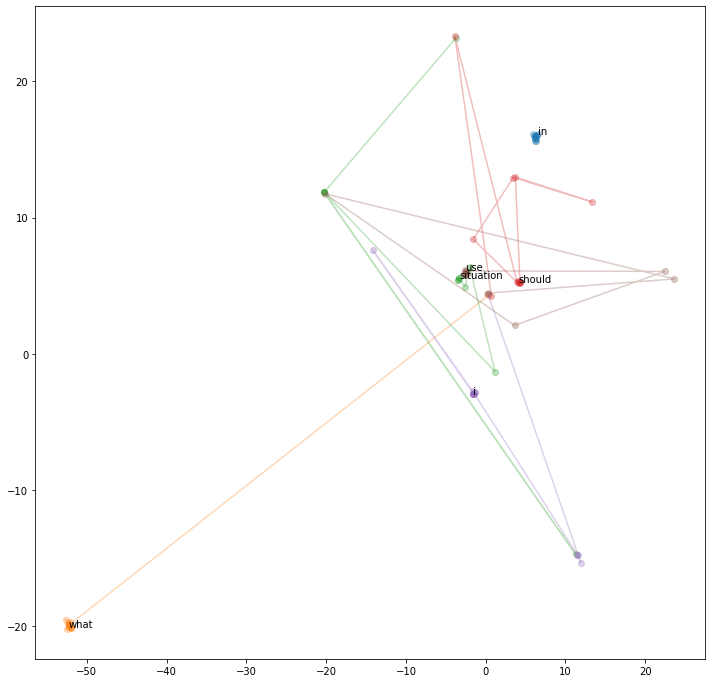

In [315]:
sentence.visualize_token_path(fit, tokens_to_follow=['in', 'what', 'situation', 'should', 'i', 'use'], 
                              print_tokens=True,
                              figsize=(12, 12))

### Sentence embedding shape

In [284]:
fit_context = umap.UMAP(n_neighbors=3, n_components=2, metric='cosine', n_epochs=None, learning_rate=1.0, 
                init='spectral', min_dist=0.1, spread=1.0, set_op_mix_ratio=1.0, local_connectivity=1.0, 
                repulsion_strength=1.0, negative_sample_rate=5, transform_queue_size=4.0, a=None, b=None, 
                random_state=None, metric_kwds=None, angular_rp_forest=False, target_n_neighbors=-1, 
                target_metric='categorical', target_metric_kwds=None, target_weight=0.5, transform_seed=0, 
                verbose=False)
_ = fit_context.fit(BASE_EMB_c) # ALL_EMBEDDINGS.size() = (n_samples, n_dimensions)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 50 separate connected components using meta-embedding (experimental)
  n_components


['[CLS]', 'how', 'do', 'you', 'improve', 'the', 'accuracy', 'of', 'a', 'neural', 'network', '?', '[SEP]']


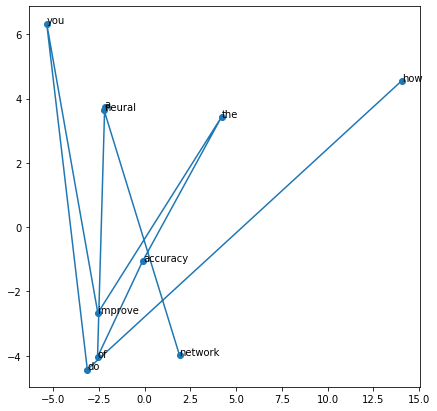

In [316]:
sentence = bert_sentences[42]
print(sentence.summary['input_tokens'])
sentence.visualize_sentence_shape(fit_context, figsize=(7, 7))